## 소개 ##

머신러닝을 연구하기 위해 진행하는 캐글 필사 프로젝트로 이 케글의 영감은 아래 글로부터 얻었습니다.

R을 빅데이터 분석 강의를 들을때 이후에는 만지지 않았는데 시간이 된다면 R로도 해보면 괜찮을 것 같습니다.

판다스의 기능 대부분이 R로부터 나온것이고 , RDBMS에서 제공하는 모든 쿼리문의 기능도 다 R에서 지원된다고 보면 됩니다.

["Exploring Survival on Titanic" by Megan Risdal, a Kernel in R on Kaggle][1]

I am going to try the following code on R tool as far as I could.

  [1]: https://www.kaggle.com/mrisdal/titanic/exploring-survival-on-the-titanic

## 변수 설명 ##

* Survived: 생존 여부 => 0 = No, 1 = Yes
* pclass: 티켓 등급 => 1 = 1st, 2 = 2nd, 3 = 3rd
* Sex: 성별
* Age: 나이
* SibSp: 함께 탑승한 형제자매(Siblings), 배우자의 수(Spouse)
* Parch: 함께 탑승한 부모(Parents), 자식의 수(Children)
* Ticket: 티켓 번호
* Fare: 운임
* Cabin: 객실 번호
* Embarked: 탑승 항구 => C = Cherbourg, Q = Queenstown, S = Southampton

In [1]:
import numpy as np
import pandas as pd
import re as re
%matplotlib inline

# targert dir for submission file
target_dir = '/kaggle/working/'
%cd ../input/titanic-machine-learning-from-disaster/

/kaggle/input/titanic-machine-learning-from-disaster


**Read Evaluate Print Loop**

In [2]:
train = pd.read_csv("train.csv", header=0, dtype={"Age": np.float64})
test  = pd.read_csv("test.csv", header=0, dtype={"Age": np.float64})
full_data = [train, test]
PassengerId = test["PassengerId"]

**함수**

In [3]:
def load_dataset():
    """
    Load Dataset
    """
    train = pd.read_csv("train.csv", header=0, dtype={"Age": np.float64})
    test  = pd.read_csv("test.csv", header = 0,dtype={"Age": np.float64})
    
    full_data = [train, test]
    PassengerId = test["PassengerId"]
    display(train.info())
    return train, test, full_data, PassengerId

# revoked load_dataset()
train, test, full_data, PassengerId = load_dataset()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

# 피처 엔지니어링 #

* 객실등급별 생존률

In [4]:
train[["Pclass", "Survived"]].groupby("Pclass", as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [5]:
def get_suvival_ratio(df, selectList:None, groupbyCol:None):
    """
    집계 피처에 대해서 생존률을 리턴
    """
    display(df[selectList].groupby([groupbyCol], as_index=False).mean())

## 1. Pclass ##
널값이 존재하지 않으며,숫자형 타입

In [6]:
get_suvival_ratio(train, ["Pclass","Survived"], "Pclass")

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


## 2. Sex ##

In [7]:
#display(train[["Sex", "Survived"]].groupby(["Sex"]).mean())
get_suvival_ratio(train, ["Sex", "Survived"], "Sex")

,Sex,Survived
0,female,0.742038
1,male,0.188908


## 3. SibSp and Parch ##
SibSp - 자손 및 배우자, Parch - 아이들/부모님 - 이 두 피처를 이용해 가족의 규모를 유추해볼 수 있는 FamilySize피처를 생성

In [8]:
for dataset in full_data:
    dataset["FamilySize"] = dataset["SibSp"] + dataset["Parch"] + 1
    
get_suvival_ratio(train, ["FamilySize", "Survived"], "FamilySize")

,FamilySize,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


In [9]:
for dataset in full_data:
    dataset["FamilySize"] = dataset["SibSp"] + dataset["Parch"] + 1
    
get_suvival_ratio(train, ["FamilySize", "Survived"], "FamilySize")

,FamilySize,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


가족의 규모가 클수록 생존률이 떨어짐을 알 수 있다.

It seems that the family size feature has a meaningful effect on the survival ratio.

* 동반승객여부 피처 생성 - IsAlone

In [10]:
for dataset in full_data:
    dataset["IsAlone"] = 0
    dataset.loc[dataset["FamilySize"]==1, "IsAlone"] = 1
    
# 동승여부에 따른 생존률
get_suvival_ratio(train, ["IsAlone", "Survived"], "IsAlone")

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


**IsAlone - 0(동행승객이 없는 경우) - 생존률이 그렇지 않은 경우보다 낮다.(의미있는 결과)**

## 4. Embarked ##

In [11]:
display(train["Embarked"].value_counts())  # 72퍼센트 가까운 승객이 사우스햄튼발 승객
display(train["Embarked"].isnull().sum())

display(train["Embarked"].value_counts() / train.shape[0])

S    644
C    168
Q     77
Name: Embarked, dtype: int64

2

S    0.722783
C    0.188552
Q    0.086420
Name: Embarked, dtype: float64

In [12]:
# 2개의 널값을 사우스햄튼으로 대치
for dataset in full_data:
    dataset["Embarked"] = dataset["Embarked"].fillna("S")
    
get_suvival_ratio(train, ["Embarked", "Survived"], "Embarked")

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


* 사우스햄튼 발 승객의 생존률이 프랑스 체르보르그(C) 및 뉴질랜드 퀸즈타운(Q) 항구에서 탑승한 승객의 생존률보다 낮음을 알수있다.

## 5. Fare ##
Fare also has some missing value and we will replace it with the median. then we categorize it into 4 ranges.

In [13]:
display(train["Fare"].isnull().sum())

# 요금을 5개의 구간으로 분할
display(pd.cut(train["Fare"], 5))
display(pd.cut(train["Fare"], 5).value_counts())
display("NaN값 체크 : ", train["Fare"].isna().sum())

0

0      (-0.512, 102.466]
1      (-0.512, 102.466]
2      (-0.512, 102.466]
3      (-0.512, 102.466]
4      (-0.512, 102.466]
             ...        
886    (-0.512, 102.466]
887    (-0.512, 102.466]
888    (-0.512, 102.466]
889    (-0.512, 102.466]
890    (-0.512, 102.466]
Name: Fare, Length: 891, dtype: category
Categories (5, interval[float64]): [(-0.512, 102.466] < (102.466, 204.932] < (204.932, 307.398] < (307.398, 409.863] < (409.863, 512.329]]

(-0.512, 102.466]     838
(102.466, 204.932]     33
(204.932, 307.398]     17
(409.863, 512.329]      3
(307.398, 409.863]      0
Name: Fare, dtype: int64

'NaN값 체크 : '

0

In [14]:
for dataset in full_data:
    dataset["Fare"] = dataset["Fare"].fillna(train["Fare"].median())
    
# 범주형 Fare피처 
train["CategoricalFare"] = pd.cut(dataset["Fare"], 5)

display(train["CategoricalFare"].value_counts())

(-0.512, 102.466]     387
(204.932, 307.398]     17
(102.466, 204.932]     13
(409.863, 512.329]      1
(307.398, 409.863]      0
Name: CategoricalFare, dtype: int64

In [15]:
# 범주형 Fare에 대한 생존률 비교
get_suvival_ratio(train, ["CategoricalFare", "Survived"], "CategoricalFare")

,CategoricalFare,Survived
0,"(-0.512, 102.466]",0.382429
1,"(102.466, 204.932]",0.461538
2,"(204.932, 307.398]",0.529412
3,"(307.398, 409.863]",NaN
4,"(409.863, 512.329]",0.000000


요금대가 384달러에서 512달러대의 승객은 전부 사망했고 또한 요금대가 128달러 이하인 승객들의 생존률도 높지 않다.

## 6. Age ##

결측치를 대치하기 위해 평균값과 표준편차를 이용해서 무작위의 값을 결측치 갯수만큼 생성해서 대치함.좋은 방법!!

Age피처의 범주형 숫자값으로 변환키위해 pd.cut()이용해 5개 범위로 분할

In [16]:
display("나이정보가 없는 승객 : ", train["Age"].isnull().sum())

'나이정보가 없는 승객 : '

177

In [17]:
for dataset in full_data:
    avg_age = dataset["Age"].mean()
    std_age = dataset["Age"].std()
    age_null_count = dataset["Age"].isnull().sum()
    
    # np.random.randint(low, high, size) - low값과 hight값에서 size만큼 무작위의 숫자값 리턴
    age_null_random_list = np.random.randint(avg_age - std_age, avg_age + std_age, age_null_count)
    dataset["Age"][np.isnan(dataset["Age"])] = age_null_random_list
    dataset["Age"] = dataset["Age"].astype(int)
    
# Age를 5개 구간으로 분할
train["CategoricalAge"] = pd.cut(train["Age"], 5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
get_suvival_ratio(train, ["CategoricalAge", "Survived"], "CategoricalAge")

,CategoricalAge,Survived
0,"(-0.08, 16.0]",0.513761
1,"(16.0, 32.0]",0.346847
2,"(32.0, 48.0]",0.391473
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


**Age lower than 15 have more chance to survive than other Age band.**

## 7. Name ##
이름으로 부터 존칭 정보를 추출

In [19]:
def get_title(name):
    """
    이름에서 해당 승객의 존칭 정보 추출
    """
    title = None
    title_search = re.search('([A-Za-z]+)\.', name)
    
    if title_search:
        title = title_search.group(1)
    return title

# 존칭 추출
for dataset in full_data:
    dataset["Title"] = dataset["Name"].apply(get_title)

In [20]:
pd.DataFrame(pd.crosstab(index = train["Title"], columns=train["Sex"]))

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


 * Title피처의 범주형 피처로 변환 후 생존률 확인

In [21]:
train["Title"].nunique()  # 17개의 유일한 갯수
title_list = train["Title"].value_counts().index.tolist()

all_title = set(title_list)
stnd_title = set(["Mr", "Miss", "Mrs", "Mlle", "Mme", "Ms"])

rare_title = list(all_title.difference(stnd_title))

In [22]:
for dataset in full_data:
    dataset["Title"] = dataset["Title"].replace(rare_title, 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

    # 존칭 타이틀로 알아보는 생존률
get_suvival_ratio(train, ["Title", "Survived"], "Title")    

,Title,Survived
0,Miss,0.702703
1,Mr,0.156673
2,Mrs,0.793651
3,Rare,0.492063


**Miss, Mrs의 생존률이 Mr보다 5배 가까이 높음. 특이한 점은 Rare가 Mr보다 높음**

**Miss, Mrs title has more chance to survive than Mr, Rare title by 5 times.**

# Data Cleaning #
데이터정제 및 범주형 타입의 데이터를 숫자형으로 변환

In [23]:
display(train["CategoricalAge"].value_counts())
display(train["Age"].describe())
display(train["Fare"].describe())

(16.0, 32.0]     444
(32.0, 48.0]     258
(-0.08, 16.0]    109
(48.0, 64.0]      69
(64.0, 80.0]      11
Name: CategoricalAge, dtype: int64

count    891.000000
mean      29.608305
std       13.499243
min        0.000000
25%       21.000000
50%       29.000000
75%       37.000000
max       80.000000
Name: Age, dtype: float64

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [24]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,CategoricalFare,CategoricalAge,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,2,0,"(-0.512, 102.466]","(16.0, 32.0]",Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,2,0,"(-0.512, 102.466]","(32.0, 48.0]",Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,"(-0.512, 102.466]","(16.0, 32.0]",Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,2,0,"(-0.512, 102.466]","(32.0, 48.0]",Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,1,1,"(-0.512, 102.466]","(32.0, 48.0]",Mr


In [25]:
for dataset in full_data:    
    try:        
        # Mapping Sex
        dataset["Sex"] = dataset["Sex"].map({"female": 0 , "male": 1}).astype(int)

        # Mapping titles
        title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
        dataset["Title"] = dataset["Title"].map(title_mapping)
        dataset["Title"] = dataset["Title"].fillna(0)

        # Mapping Embarked
        dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

        # Mapping Fare based on 1st quartile, 2nd quartile, 3rd quatile
        dataset.loc[dataset["Fare"] <= 7.91, 'Fare'] = 0
        dataset.loc[(dataset["Fare"] > 7.91) & (dataset["Fare"] <= 14.454), "Fare"] = 1
        dataset.loc[(dataset["Fare"] > 14.454) & (dataset["Fare"] <= 31), "Fare"] = 2
        dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
        dataset['Fare'] = dataset['Fare'].astype(int)

        # Mapping Age
        dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
        dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
        dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
        dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
        dataset.loc[ dataset['Age'] > 64, 'Age'] = 4
    except ValueError:
        pass
    except IndexError:
        pass

# Feature drop
drop_elements = ["PassengerId", "Name", "Ticket", "Cabin", "SibSp", "Parch", "FamilySize"]
train = train.drop(drop_elements, axis = 1, errors = "ignore")
train = train.drop(["CategoricalAge", "CategoricalFare"], axis = 1, errors = "ignore")
test  = test.drop(drop_elements, axis = 1, errors = "ignore")

display (train.head(n=3))
display(test.head(n=3))

train = train.values
test  = test.values

,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone,Title
0,0,3,1,1,0,0,0,1
1,1,1,0,2,3,1,0,3
2,1,3,0,1,1,0,1,2


,Pclass,Sex,Age,Fare,Embarked,IsAlone,Title
0,3,1,2,0,2,1,1.0
1,3,0,2,0,0,0,3.0
2,2,1,3,1,2,1,1.0


# 분류기 비교 #
## 관련 라이브러리

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# classification
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB

# decomposition
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

#회귀
from sklearn.linear_model import LogisticRegression

* Modulization
* [StratifiedKFold Official Document](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html)

**모듈화**

In [27]:
def train_predict(X, y, classifiers: list):
    """
    학습 피처와 레이블 값을 인자로 받아서  정확도와 분류기별 정확도를 DataFrame으로 리턴
    """
    # StratifiedKFold와 ShuffleSplit의 기능을 갖고있음
    # 검증 인덱스와 학습인덱스를 나누어서 리턴함
    # 인자는 피처배열과 레이블 배열을 1차원 배열의 형태로 전달
    sss = StratifiedShuffleSplit(n_splits = 10, test_size = .3, random_state=0)
    
    accuracy = {}
    log_cols = ['Classifiers', 'Accuracy']
    
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        for clf in classifiers:
            clf.fit(X_train, y_train)
            train_prediction = clf.predict(X_test)
            
            acc = accuracy_score(y_test, train_prediction)
            
            model = clf.__class__.__name__
            
            if model in accuracy:
                accuracy[model] += acc
            else:
                accuracy[model] = acc
                
    for k, _ in accuracy.items():
        accuracy[k] = accuracy[k] / 10.0
        
    # 리턴할 데이터프레임 생성    
    accuracy_df = pd.DataFrame([[k, v] for k, v in accuracy.items()], columns = log_cols)
    
    return accuracy, accuracy_df

def visualize_accuracy(accuracy_df):
    """
    분류기별 정확도를 시각화(barplot)
    """
    # 시각화
    plt.xlabel("Accuracy")
    plt.title("Accuracy by Classifiers")

    # color='b'옵션을 주면 색이 파란색 하나로 통일
    sns.barplot(x = "Accuracy", y="Classifiers", data = accuracy_df)
    sns.set_color_codes("muted")
def main_process(X, y, classifiers):
    accuracy, accuracy_df = train_predict(X, y, classifiers)
    visualize_accuracy(accuracy_df)

**REPL(Read Evaluate Print Loop)**

In [28]:
classifiers = [
    KNeighborsClassifier(n_neighbors = 10),
    SVC(C = 0.05, gamma="auto", probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=500),
    AdaBoostClassifier(n_estimators=500, learning_rate = 0.5),
    GradientBoostingClassifier(learning_rate=0.5, n_estimators = 500),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()
]

log_cols = ["Classifiers", "Accuracy"]

# train_index와 test_index를 리턴함
sss= StratifiedShuffleSplit(n_splits = 10, test_size = .1, random_state = 0)

X = train[:, 1:]
y = train[:, 0]

accuracy = {}

for train_idx, test_idx in sss.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    for clf in classifiers:
        clf.fit(X_train, y_train)
        train_prediction = clf.predict(X_test)
        
        acc = accuracy_score(y_test, train_prediction)
        
        model = clf.__class__.__name__
        if model in accuracy:
            accuracy[model] += acc
        else:
            accuracy[model] = acc

for k, _ in accuracy.items():
    accuracy[k] = accuracy[k] / 10.0
    
accuracy_df = pd.DataFrame([[k, v] for k, v in accuracy.items()], columns = log_cols)

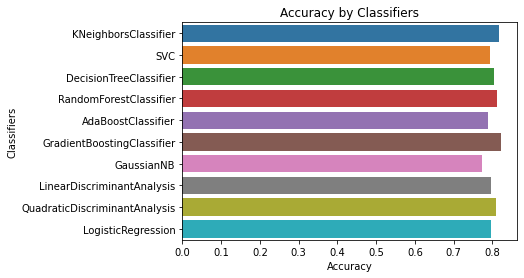

In [29]:
# 시각화
plt.xlabel("Accuracy")
plt.title("Accuracy by Classifiers")

# color='b'옵션을 주면 색이 파란색 하나로 통일
sns.barplot(x = "Accuracy", y="Classifiers", data = accuracy_df)
sns.set_color_codes("muted")

**함수 호출**

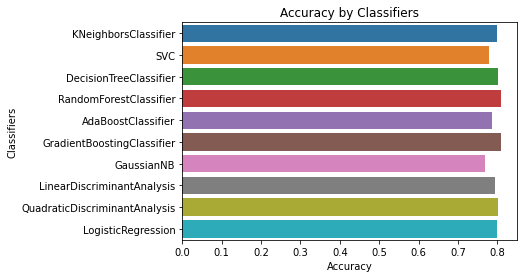

In [30]:
# 함수로 재작성 후 수행
main_process(X, y, classifiers)

# Prediction #
SVM를 최종 사용해서 학습 및 예측

In [31]:
final_clf = SVC()
final_clf.fit(X, y)

result = final_clf.predict(test)

final_submission = pd.DataFrame(data = {"PassengerId": PassengerId, "Survived": result})

display(final_submission.head(n=3))

final_submission.to_csv(target_dir + "titanic_survival_prediction.csv")

,PassengerId,Survived
0,892,0
1,893,1
2,894,0


In [32]:
survivor_prediction = pd.read_csv(target_dir + "titanic_survival_prediction.csv")
display(survivor_prediction.head(n=3))
display(survivor_prediction.tail(n=3))

,Unnamed: 0,PassengerId,Survived
0,0,892,0
1,1,893,1
2,2,894,0


,Unnamed: 0,PassengerId,Survived
415,415,1307,0
416,416,1308,0
417,417,1309,0
